In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [ ]:
# ! pip install --upgrade pip
# ! pip install --user numpy scipy matplotlib iminuit boost_histogram sweights pandas uproot

In [2]:
import os
import numpy as np
from scipy.stats import norm, expon, uniform
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit.pdg_format import pdg_format
import boost_histogram as bh

sweights is a package which can implement various different methods for projecting out a particular component in a control variable based on the distribution in a discriminating variable.
It is based on the work described in arXiv:2112.04574.

In [3]:
from sweights import SWeight # for classic sweights
from sweights import cov_correct, approx_cov_correct # for covariance corrections

# Generate toys

We generate toys for an invariant mass and a decay time distribution. The signal model is a Gaussian with mean 0.5 and width 0.1 to describe the mass and an exponential decay with lifetime 0.5. The background is parametrized with a falling exponential distribution with decay constant 1 for the mass and a flat decay time distribution.

In [4]:
# set a reproducible seed
np.random.seed(21011987)

Ns = 5000
Nb = 5000
ypars = [Ns,Nb]

# mass
mrange = (0,1)
mu = 0.5
sg = 0.1
lb = 1
mpars = [mu,sg,lb]

# decay time
trange = (0,1)
tlb = 2
tpars = [tlb]

# generate the toy
def generate(Ns,Nb,mu,sg,lb,tlb,poisson=False,ret_true=False):

    Nsig = np.random.poisson(Ns) if poisson else Ns
    Nbkg = np.random.poisson(Nb) if poisson else Nb

    sigM = norm(mu,sg)
    bkgM = expon(mrange[0], lb)

    sigT = expon(trange[0], tlb)
    bkgT = uniform(trange[0],trange[1]-trange[0])

    # generate
    sigMflt = sigM.cdf(mrange)
    bkgMflt = bkgM.cdf(mrange)
    sigTflt = sigT.cdf(trange)
    bkgTflt = bkgT.cdf(trange)

    sigMvals = sigM.ppf( np.random.uniform(*sigMflt,size=Nsig) )
    sigTvals = sigT.ppf( np.random.uniform(*sigTflt,size=Nsig) )

    bkgMvals = bkgM.ppf( np.random.uniform(*bkgMflt,size=Nbkg) )
    bkgTvals = bkgT.ppf( np.random.uniform(*bkgTflt,size=Nbkg) )

    Mvals = np.concatenate( (sigMvals, bkgMvals) )
    Tvals = np.concatenate( (sigTvals, bkgTvals) )

    truth = np.concatenate( ( np.ones_like(sigMvals), np.zeros_like(bkgMvals) ) )

    if ret_true:
        return np.stack( (Mvals,Tvals,truth), axis=1 )
    else:
        return np.stack( (Mvals,Tvals), axis=1 )

toy = generate(Ns,Nb,mu,sg,lb,tlb,ret_true=True)

# Plot the data and overlay the fit pdfs (without fitting)

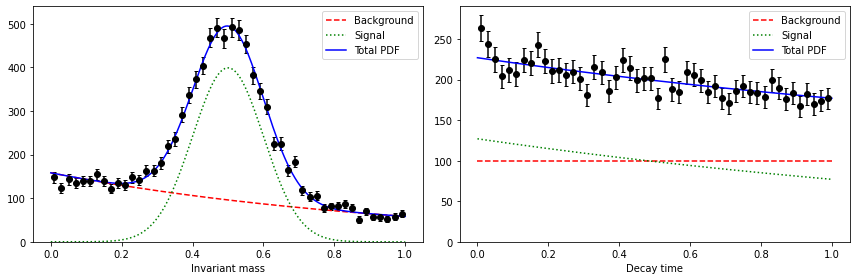

In [5]:
# useful function for plotting data points with error bars
def myerrorbar(data, ax, bins, range, wts=None, label=None, col=None):
    col = col or 'k'
    nh, xe = np.histogram(data,bins=bins,range=range)
    cx = 0.5*(xe[1:]+xe[:-1])
    err = nh**0.5
    if wts is not None:
        whist = bh.Histogram( bh.axis.Regular(bins,*range), storage=bh.storage.Weight() )
        whist.fill( data, weight = wts )
        cx = whist.axes[0].centers
        nh = whist.view().value
        err = whist.view().variance**0.5

    ax.errorbar(cx, nh, err, capsize=2,label=label,fmt=f'{col}o')

# define the mass pdf for plotting etc.
def mpdf(x, Ns, Nb, mu, sg, lb, comps=['sig','bkg']):

    sig  = norm(mu,sg)
    sigN = np.diff( sig.cdf(mrange) )

    bkg  = expon(mrange[0], lb)
    bkgN = np.diff( bkg.cdf(mrange) )

    tot = 0
    if 'sig' in comps: tot += Ns * sig.pdf(x) / sigN
    if 'bkg' in comps: tot += Nb * bkg.pdf(x) / bkgN

    return tot

# define time pdf for plotting etc.
def tpdf(x, Ns, Nb, tlb, comps=['sig','bkg']):

    sig  = expon(trange[0],tlb)
    sigN = np.diff( sig.cdf(trange) )

    bkg  = uniform(trange[0],trange[1]-trange[0])
    bkgN = np.diff( bkg.cdf(trange) )

    tot = 0
    if 'sig' in comps: tot += Ns * sig.pdf(x) / sigN
    if 'bkg' in comps: tot += Nb * bkg.pdf(x) / bkgN

    return tot

# define plot function
def plot(toy, draw_pdf=True):

    nbins = 50

    fig, ax = plt.subplots(1,2,figsize=(12,4))

    myerrorbar(toy[:,0],ax[0],bins=nbins,range=mrange)
    myerrorbar(toy[:,1],ax[1],bins=nbins,range=trange)

    if draw_pdf:
        m = np.linspace(*mrange,400)
        mN = (mrange[1]-mrange[0])/nbins

        bkgm = mpdf(m, *(ypars+mpars),comps=['bkg'])
        sigm = mpdf(m, *(ypars+mpars),comps=['sig'])
        totm = bkgm + sigm

        ax[0].plot(m, mN*bkgm, 'r--', label='Background')
        ax[0].plot(m, mN*sigm, 'g:' , label='Signal')
        ax[0].plot(m, mN*totm, 'b-' , label='Total PDF')

        t = np.linspace(*trange,400)
        tN = (trange[1]-trange[0])/nbins

        bkgt = tpdf(t, *(ypars+tpars),comps=['bkg'])
        sigt = tpdf(t, *(ypars+tpars),comps=['sig'])
        tott = bkgt + sigt

        ax[1].plot(t, tN*bkgt, 'r--', label='Background')
        ax[1].plot(t, tN*sigt, 'g:' , label='Signal')
        ax[1].plot(t, tN*tott, 'b-' , label='Total PDF')

    ax[0].set_xlabel('Invariant mass')
    ax[0].set_ylim(bottom=0)
    ax[0].legend()

    ax[1].set_xlabel('Decay time')
    ax[1].set_ylim(bottom=0)
    ax[1].legend()

    fig.tight_layout()

plot(toy)

# Independence

The sweight method is only valid for independent variables. We can for example calculate the kendall rank coefficient to test if that is given.

Kendall Tau: -0.017 ± 0.010


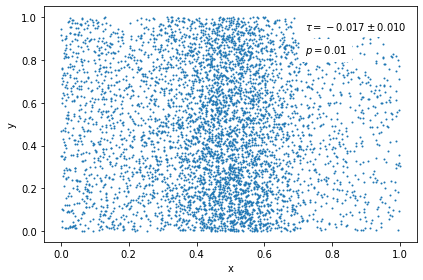

In [6]:
from sweights import kendall_tau # for an independence test
from sweights import plot_indep_scatter

kts = kendall_tau(toy[:,0],toy[:,1])
print('Kendall Tau:', pdg_format( kts[0], kts[1] ) )
plot_indep_scatter(toy[:,0],toy[:,1],reduction_factor=2);

# Fit of toy mass distribution

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.684e+05                 │              Nfcn = 135              │
│ EDM = 7.37e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Ns   │  5.11e3   │  0.11e3   │            │            │    0    │  10000  │       │
│ 1 │ Nb   │  4.89e3   │  0.11e3   │            │            │    0    │  10000  │       │
│ 2 │ mu   │  0.4981   │  0.0021   │            │            │    0    │    1    │       │
│ 3 │ sg   │  0.1031   │  0.0022   │            │            │    0    │    1    │       │
│ 4 │ lb   │   1.07    │   0.06    │            │            │    0    │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │          Ns          Nb          mu          sg          lb │
├────┼─────────────────────────────────────────────────────────────┤
│ Ns │    1.22e+04    -0.007e6   -7.889e-3  123.859e-3      -1.438 │
│ Nb │    -0.007e6     1.2e+04    7.885e-3 -123.828e-3       1.438 │
│ mu │   -7.889e-3    7.885e-3    4.46e-06       -0e-6      -33e-6 │
│ sg │  123.859e-3 -123.828e-3       -0e-6    4.72e-06      -24e-6 │
│ lb │      -1.438       1.438      -33e-6      -24e-6     0.00411 │
└────┴─────────────────────────────────────────────────────────────┘

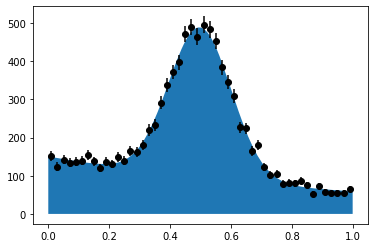

In [7]:
# define mass pdf for iminuit fitting
def mpdf_min(x, Ns, Nb, mu, sg, lb):
    return (Ns+Nb, mpdf(x, Ns, Nb, mu, sg, lb) )

mi = Minuit( ExtendedUnbinnedNLL(toy[:,0], mpdf_min), Ns=Ns, Nb=Nb, mu=mu, sg=sg, lb=lb )
mi.limits['Ns'] = (0,Ns+Nb)
mi.limits['Nb'] = (0,Ns+Nb)
mi.limits['mu'] = mrange
mi.limits['sg'] = (0,mrange[1]-mrange[0])
mi.limits['lb'] = (0,10)

mi.migrad()
mi.hesse()
display(mi) # only valid for ipython notebooks

# Construct the sweights

In [8]:
# define estimated functions
spdf = lambda m: mpdf(m,*mi.values,comps=['sig'])
bpdf = lambda m: mpdf(m,*mi.values,comps=['bkg'])

# make the sweighter
sweighter = SWeight( toy[:,0], [spdf,bpdf], [mi.values['Ns'],mi.values['Nb']], (mrange,), method='summation', compnames=('sig','bkg'), verbose=True, checks=True )

Initialising sweight with the summation method:
    PDF normalisations:
	 0 5107.224408953951
	 1 4892.156809977973
    W-matrix:
	[[1.38699027e-04 5.96207082e-05]
	 [5.96207082e-05 1.42184207e-04]]
    A-matrix:
	[[ 8795.16287077 -3687.98933136]
	 [-3687.98933136  8579.57827947]]
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 1.00011709e+00 -1.32635061e-04]
	 [-1.57992863e-04  1.00004886e+00]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  5107.2244 |  5107.2244 |     0.00% |
	  1        |  4892.1568 |  4892.1568 |    -0.00% |


# Plot sWeights

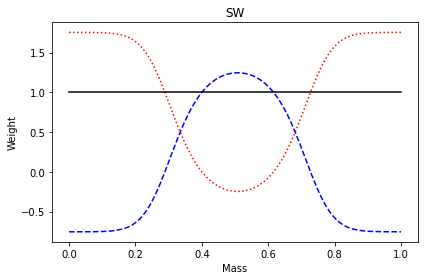

In [9]:
def plot_wts(x, sw, bw, title=None):
    fig,ax = plt.subplots()
    ax.plot(x, sw, 'b--', label='Signal')
    ax.plot(x, bw, 'r:' , label='Background')
    ax.plot(x, sw+bw, 'k-', label='Sum')
    ax.set_xlabel('Mass')
    ax.set_ylabel('Weight')
    if title: ax.set_title(title)
    fig.tight_layout()

# plot weights
x = np.linspace(*mrange,400)
swp = sweighter.get_weight(0,x)
bwp = sweighter.get_weight(1,x)
plot_wts(x, swp, bwp, 'SW')

# Use sWeights to perform fit of decay time distribution

The minuit fit itself will underestimate the uncertainties so they must be corrected.

In [10]:
# define weighted nll
def wnll(tlb, tdata, wts):
    sig  = expon(trange[0],tlb)
    sigN = np.diff( sig.cdf(trange) )
    return -np.sum( wts * np.log( sig.pdf( tdata ) / sigN ) )

# define signal only time pdf for cov corrector
def tpdf_cor(x, tlb):
    return tpdf(x,1,0,tlb,['sig'])

flbs=[]

# get the weights
wts = sweighter.get_weight(0,toy[:,0])

# define the nll
nll = lambda tlb: wnll(tlb, toy[:,1], wts)

# do the minimisation
tmi = Minuit( nll, tlb=tlb )
tmi.limits['tlb'] = (1,3)
tmi.errordef = Minuit.LIKELIHOOD
tmi.migrad()
tmi.hesse()

# and do the correction
fval = np.array(tmi.values)
flbs.append(fval[0])
fcov = np.array( tmi.covariance.tolist() )

# first order correction
ncov = approx_cov_correct(tpdf_cor, toy[:,1], wts, fval, fcov, verbose=False)

# second order correction
hs  = tpdf_cor
ws  = lambda m: sweighter.get_weight(0,m)
W   = sweighter.Wkl

# these derivatives can be done numerically but for the sweights / COW case it's straightfoward to compute them
ws = lambda Wss, Wsb, Wbb, gs, gb: (Wbb*gs - Wsb*gb) / ((Wbb-Wsb)*gs + (Wss-Wsb)*gb)
dws_Wss = lambda Wss, Wsb, Wbb, gs, gb: gb * ( Wsb*gb - Wbb*gs ) / (-Wss*gb + Wsb*gs + Wsb*gb - Wbb*gs)**2
dws_Wsb = lambda Wss, Wsb, Wbb, gs, gb: ( Wbb*gs**2 - Wss*gb**2 ) / (Wss*gb - Wsb*gs - Wsb*gb + Wbb*gs)**2
dws_Wbb = lambda Wss, Wsb, Wbb, gs, gb: gs * ( Wss*gb - Wsb*gs ) / (-Wss*gb + Wsb*gs + Wsb*gb - Wbb*gs)**2

tcov = cov_correct(hs, [spdf,bpdf], toy[:,1], toy[:,0], wts, [mi.values['Ns'],mi.values['Nb']], fval, fcov, [dws_Wss,dws_Wsb,dws_Wbb],[W[0,0],W[0,1],W[1,1]], verbose=False)
print(f'- covariance corrected {fval[0]:.2f} +/- {fcov[0,0]**0.5:.2f} ---> {fval[0]:.2f} +/- {tcov[0,0]**0.5:.2f}')

- covariance corrected 1.71 +/- 0.14 ---> 1.71 +/- 0.19


# Plot the weighted decay distributions and the fit result

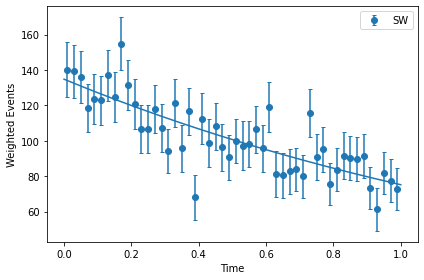

In [11]:
def plot_tweighted(x, wts, wtnames=[], funcs=[]):

    fig, ax = plt.subplots()

    t = np.linspace(*trange,400)
    N = (trange[1]-trange[0])/50

    for i, wt in enumerate(wts):
        label = None
        if i<len(wtnames): label = wtnames[i]
        myerrorbar(x, ax, bins=50, range=trange, wts=wt, label=label, col=f'C{i}')
        if i<len(funcs):
            ax.plot(t,N*funcs[i](t),f'C{i}-')

    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Weighted Events')
    fig.tight_layout()

swf  = lambda t: tpdf(t, mi.values['Ns'], 0, flbs[0], comps=['sig'] )
sws  = sweighter.get_weight(0, toy[:,0])

plot_tweighted(toy[:,1], [sws], ['SW'], funcs=[swf] )

# Write the sWeights to a root file

In [12]:
import pandas as pd

df = pd.DataFrame( )
df['mass'] = toy[:,0]
df['time'] = toy[:,1]
df['sw_sws'] = sweighter.get_weight(0, df['mass'].to_numpy() )
df['sw_bws'] = sweighter.get_weight(1, df['mass'].to_numpy() )

import uproot

with uproot.recreate('outf.root') as f:
    f['tree'] = df

print(df)

          mass      time    sw_sws    sw_bws
0     0.276401  0.287028 -0.129313  1.129223
1     0.302426  0.426394  0.150924  0.848999
2     0.578586  0.449921  1.149476 -0.149511
3     0.373953  0.741222  0.839109  0.160843
4     0.515549  0.598659  1.244910 -0.244940
...        ...       ...       ...       ...
9995  0.846222  0.426296 -0.706615  1.706501
9996  0.166248  0.153495 -0.711678  1.711563
9997  0.535665  0.266288  1.231984 -0.232015
9998  0.357202  0.365763  0.708016  0.291931
9999  0.643105  0.593656  0.832079  0.167873

[10000 rows x 4 columns]


# Custom orthogonal weight functions

In [13]:
from sweights import Cow     # for custom orthogonal weight functions

# unity
Im = 1
# sweight equiavlent
# Im = lambda m: mpdf(m,*mi.values) / (mi.values['Ns'] + mi.values['Nb'] )

# make the cow
cw = Cow(mrange, spdf, bpdf, Im, verbose=True)

Initialising COW:
    W-matrix:
	[[2.73492037 0.97050271]
	  [0.97050271 1.07239023]]
    A-matrix:
	[[ 0.53861176 -0.48743839]
	  [-0.48743839  1.37362336]]


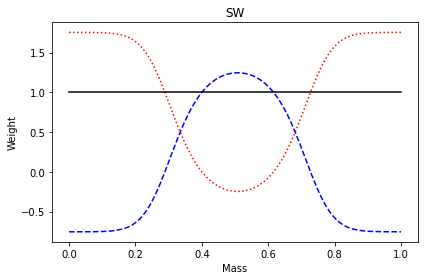

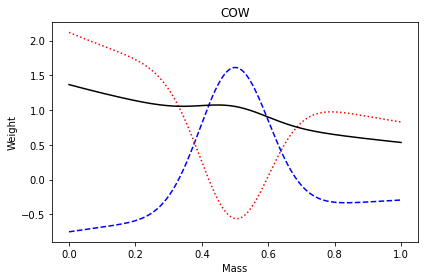

In [14]:
for meth, cls in zip( ['SW','COW'], [sweighter,cw] ):

    # plot weights
    x = np.linspace(*mrange,400)
    swp = cls.get_weight(0,x)
    bwp = cls.get_weight(1,x)
    plot_wts(x, swp, bwp, meth)

In [15]:
# get the weights
wts = cw.get_weight(0,toy[:,0])

# define the nll
nll = lambda tlb: wnll(tlb, toy[:,1], wts)

# do the minimisation
tmi = Minuit( nll, tlb=tlb )
tmi.limits['tlb'] = (1,3)
tmi.errordef = Minuit.LIKELIHOOD
tmi.migrad()
tmi.hesse()

# and do the correction
fval = np.array(tmi.values)
flbs.append(fval[0])
fcov = np.array( tmi.covariance.tolist() )

# first order correction
ncov = approx_cov_correct(tpdf_cor, toy[:,1], wts, fval, fcov, verbose=False)

# second order correction
hs  = tpdf_cor
ws  = lambda m: cw.get_weight(0,m)
W   = cw.Wkl

# these derivatives can be done numerically but for the sweights / COW case it's straightfoward to compute them
ws = lambda Wss, Wsb, Wbb, gs, gb: (Wbb*gs - Wsb*gb) / ((Wbb-Wsb)*gs + (Wss-Wsb)*gb)
dws_Wss = lambda Wss, Wsb, Wbb, gs, gb: gb * ( Wsb*gb - Wbb*gs ) / (-Wss*gb + Wsb*gs + Wsb*gb - Wbb*gs)**2
dws_Wsb = lambda Wss, Wsb, Wbb, gs, gb: ( Wbb*gs**2 - Wss*gb**2 ) / (Wss*gb - Wsb*gs - Wsb*gb + Wbb*gs)**2
dws_Wbb = lambda Wss, Wsb, Wbb, gs, gb: gs * ( Wss*gb - Wsb*gs ) / (-Wss*gb + Wsb*gs + Wsb*gb - Wbb*gs)**2

tcov = cov_correct(hs, [spdf,bpdf], toy[:,1], toy[:,0], wts, [mi.values['Ns'],mi.values['Nb']], fval, fcov, [dws_Wss,dws_Wsb,dws_Wbb],[W[0,0],W[0,1],W[1,1]], verbose=False)
print(f'- covariance corrected {fval[0]:.2f} +/- {fcov[0,0]**0.5:.2f} ---> {fval[0]:.2f} +/- {tcov[0,0]**0.5:.2f}')

- covariance corrected 1.64 +/- 0.13 ---> 1.64 +/- 0.18


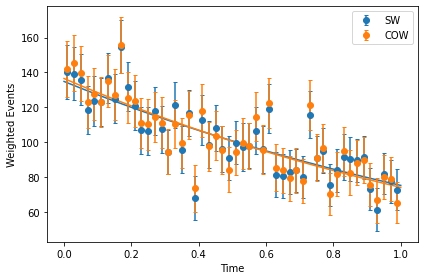

In [16]:
### Plot the weighted decay distributions and the fit result
swf  = lambda t: tpdf(t, mi.values['Ns'], 0, flbs[0], comps=['sig'] )
cowf = lambda t: tpdf(t, mi.values['Ns'], 0, flbs[1], comps=['sig'] )
sws  = sweighter.get_weight(0, toy[:,0])
scow = cw.get_weight(0, toy[:,0])

plot_tweighted(toy[:,1], [sws,scow], ['SW','COW'], funcs=[swf,cowf] )

In [17]:
df = pd.DataFrame( )
df['mass'] = toy[:,0]
df['time'] = toy[:,1]
df['sw_sws'] = sweighter.get_weight(0, df['mass'].to_numpy() )
df['sw_bws'] = sweighter.get_weight(1, df['mass'].to_numpy() )
df['cow_sws'] = cw.get_weight(0, df['mass'].to_numpy() )
df['cow_bws'] = cw.get_weight(1, df['mass'].to_numpy() )

with uproot.recreate('outf.root') as f:
    f['tree'] = df

print(df)

          mass      time    sw_sws    sw_bws   cow_sws   cow_bws
0     0.276401  0.287028 -0.129313  1.129223 -0.372759  1.446466
1     0.302426  0.426394  0.150924  0.848999 -0.220921  1.282285
2     0.578586  0.449921  1.149476 -0.149511  1.099331 -0.159718
3     0.373953  0.741222  0.839109  0.160843  0.481153  0.576620
4     0.515549  0.598659  1.244910 -0.244940  1.590285 -0.553110
...        ...       ...       ...       ...       ...       ...
9995  0.846222  0.426296 -0.706615  1.706501 -0.332575  0.950587
9996  0.166248  0.153495 -0.711678  1.711563 -0.631136  1.801133
9997  0.535665  0.266288  1.231984 -0.232015  1.494705 -0.483188
9998  0.357202  0.365763  0.708016  0.291931  0.282588  0.772361
9999  0.643105  0.593656  0.832079  0.167873  0.364086  0.456587

[10000 rows x 6 columns]
